In [1]:
import numpy as np
import pandas as pd
from sko.GA import GA_TSP
from sko.ACA import ACA_TSP
from sko.SA import SA_TSP
from sko.PSO import PSO
from utils import parse_UK_Data, generate_coordinates
from scipy import spatial
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt


#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
%config Completer.use_jedi = False

dataset = "../datasets/UK10_1.txt"


meta_data, distance_data, station_data = parse_UK_Data(dataset)

In [2]:
meta_data

,Customer Amount,Vehicle Curb Weight(kg),Max Load(kg),Minimum Speed(km/h),Maximum Speed(km/h)
0,10,6350,3650,20,90


In [3]:
# Convert distance data to numpy matrix
num_points = station_data.shape[0]
distance_matrix = distance_data.to_numpy()

In [4]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [5]:
mean = np.mean(distance_matrix)
std = np.std(distance_matrix)
#distance_matrix = (distance_matrix - mean)/std
distance_matrix = NormalizeData(distance_matrix)

In [6]:
#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
#station_coordinates = generate_coordinates(station_data)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

In [7]:
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist

points_distance_matrix = squareform(pdist(points_coordinate))


In [8]:
def cal_total_distance(routine):
    num_points, = routine.shape
    #print(routine)
    #print([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])
    return sum([points_distance_matrix[routine[i], routine[(i + 1)]]**2 for i in range(num_points-1)])

In [9]:
import sys
def start_constraint(routine):
    if routine[0] == 0:
        return -1
    return 10000

# def has_two_vehicles(routine):
#     if

def constraint_capacity(routine):
    capacity = 0
    c = 0
    for i in routine:
        if i != 0:
            c += int(station_data.loc[i,"Demand(kg)"])
        else:
            capacity = max(capacity, c)
            c = 0
            
    capacity = max(capacity, c)
    return (capacity - int(meta_data.loc[0,"Max Load(kg)"])) * 1

In [10]:
# [ga_1,ga_2,ga_2,ga_3]
# ga_1.Chrom != ga_2.Chrom ..... != g_n.Chrom
#np.concatenate([np.zeros(shape=(ga.size_pop, num_vehicle - 1), dtype=np.int), ga.Chrom+1], axis=1)

In [20]:
ga = GA_TSP(func=cal_total_distance, n_dim=10,
              size_pop=200, max_iter=100,prob_mut=0.5)
# ga = ACA_TSP(func=cal_total_distance, n_dim=11,
#               size_pop=200, max_iter=200,
#               distance_matrix=distance_matrix)

num_vehicle = 2
ga.Chrom = np.concatenate([np.zeros(shape=(ga.size_pop, num_vehicle ), dtype=np.int), ga.Chrom+1], axis=1)
ga.has_constraint = True
ga.constraint_ueq = [start_constraint,constraint_capacity]

best_x, best_y = ga.run()
print(best_x)
print(best_y)

[ 0  3  6  9  2 10  0  1  5  4  7  8]
[8.39397445]


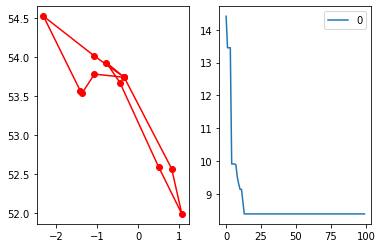

[ 0  3  6  9  2 10  0  1  5  4  7  8  0]


In [21]:
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(best_points_coordinate[:, 1], best_points_coordinate[:, 0], 'o-r')
pd.DataFrame(ga.generation_best_Y).cummin().plot(ax=ax[1])
plt.show()
print(best_points_)

In [75]:
sa_tsp = SA_TSP(func=cal_total_distance, x0=[0,1,2,3,4], T_max=100, T_min=1, L=10 * 5)

sa_tsp.has_constraint = True 
sa_tsp.constraint_ueq = [start_constraint,constraint_capacity]
best_points, best_distance = sa_tsp.run()
print(best_points, best_distance, cal_total_distance(best_points))

[3 1 0 2 4] 0.7075096583644365 0.7075096583644365


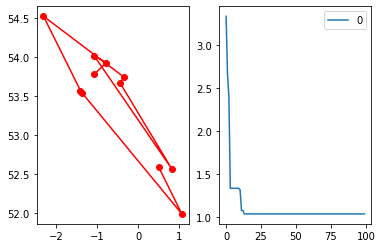

[ 0  8 10  1  0  2  5  3  9  6  7  4  0]


In [70]:
fig, ax = plt.subplots(1, 2)
#best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = points_coordinate[best_points, :]
ax[0].plot(best_points_coordinate[:, 1], best_points_coordinate[:, 0], 'o-r')
pd.DataFrame(ga.generation_best_Y).cummin().plot(ax=ax[1])
plt.show()
print(best_points_)

In [22]:
temp_split =  np.split(best_points_, np.where(best_points_== 0.)[0])
vehicle_routes_seperated = []
for v_route in temp_split:
    if v_route.size > 1:
        vehicle_routes_seperated.append(v_route)
vehicle_routes_seperated

[array([ 0,  3,  6,  9,  2, 10]), array([0, 1, 5, 4, 7, 8])]

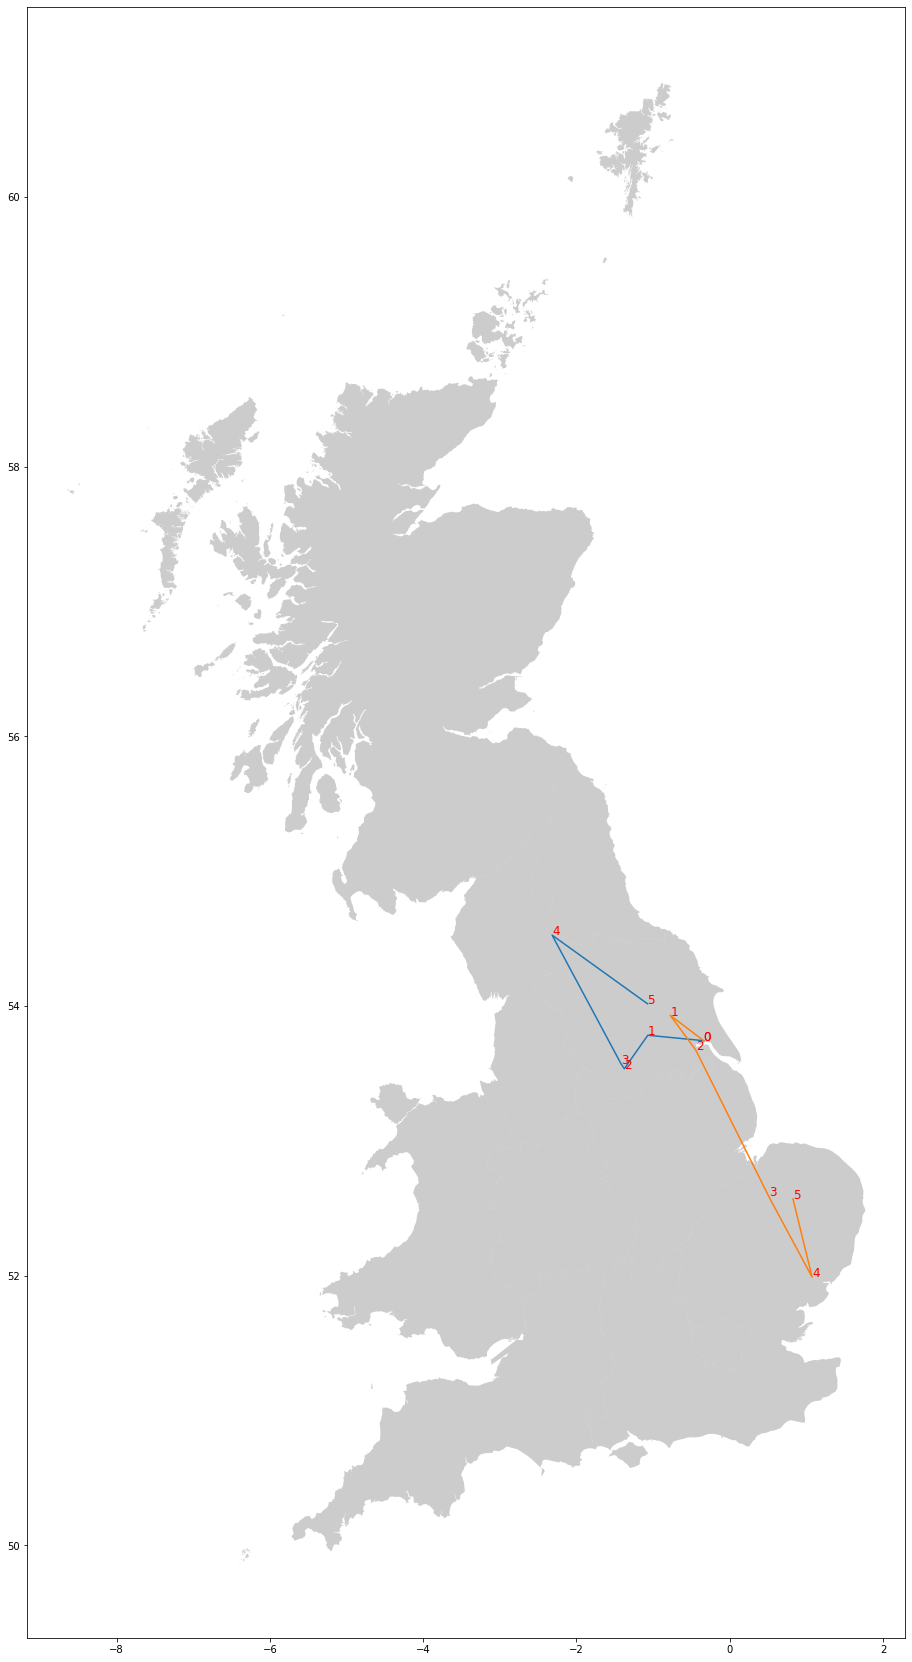

In [23]:
fig, ax = plt.subplots(figsize=(30,30))# add .shp mapfile to axes
dbf.plot(ax=ax, alpha=0.4,color="grey")

for vehicle_stops in vehicle_routes_seperated:
    vehicle_stops_coordinates=points_coordinate[vehicle_stops, :]
    ax.plot(vehicle_stops_coordinates[:, 1], vehicle_stops_coordinates[:, 0])
    for i, (x, y) in enumerate(zip(vehicle_stops_coordinates[:, 1], vehicle_stops_coordinates[:, 0])):
        ax.text(x, y, str(i), color="red", fontsize=12)
